In [48]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=50
dims_latent = 16                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 0)
train_size=0.1

Cuda installed! Running on GPU 0 GeForce RTX 2080 Ti!


# MNIST Example

In [3]:
# Transforms
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

# Datasets and dataloaders
ds = MNIST("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

trainds = Subset(ds, [0])

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 1:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())



Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 {'epoch': 0, 'train_mse': 0.22403331100940704, 'train_awi1d_loss': 179.6823272705078}
 argidx T, v:  0 881


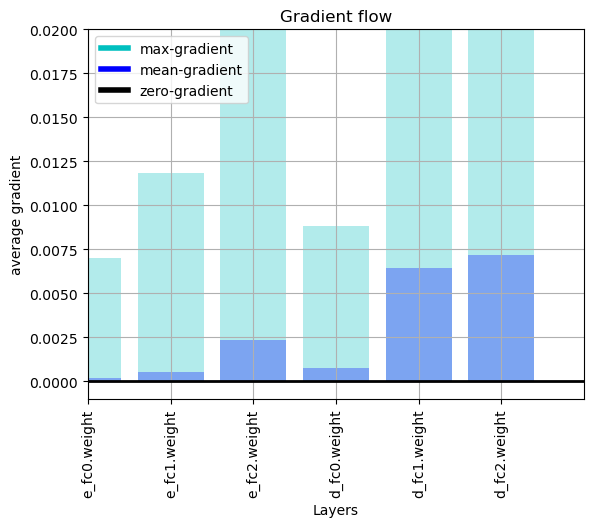

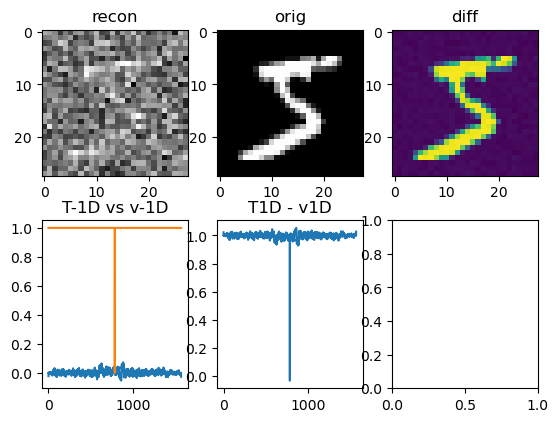

 20% (10 of 50) |####                    | Elapsed Time: 0:00:04 ETA:   0:00:15
 {'epoch': 10, 'train_mse': 0.1712489128112793, 'train_awi1d_loss': 0.46610069274902344}
 argidx T, v:  0 783


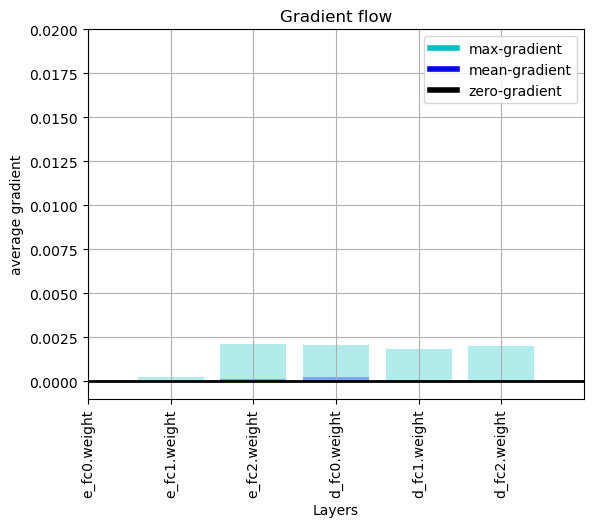

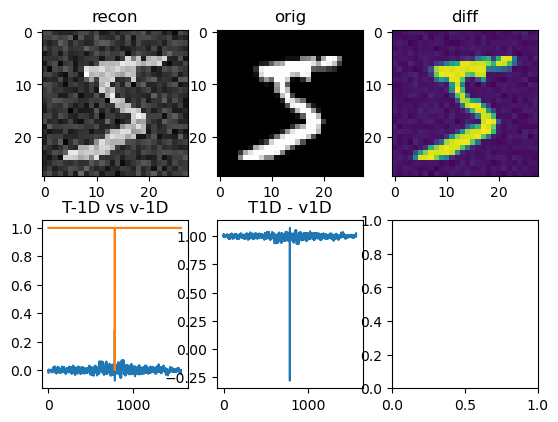

 40% (20 of 50) |#########               | Elapsed Time: 0:00:09 ETA:   0:00:11
 {'epoch': 20, 'train_mse': 0.08745667338371277, 'train_awi1d_loss': 0.3289704918861389}
 argidx T, v:  0 783


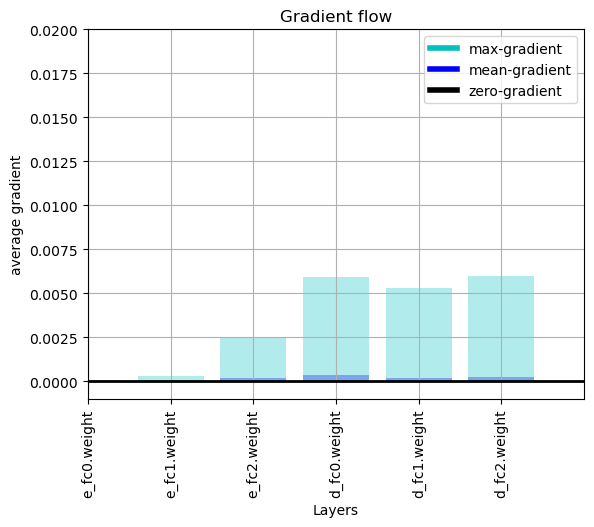

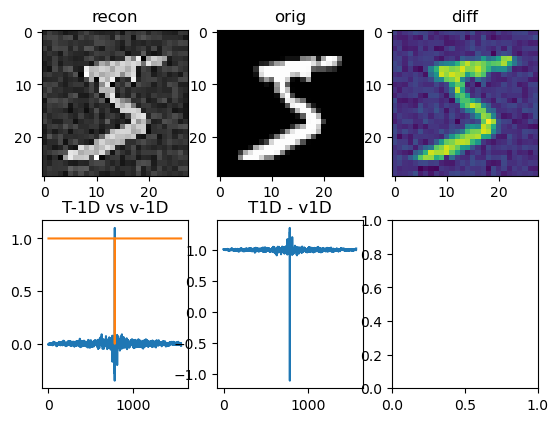

 60% (30 of 50) |##############          | Elapsed Time: 0:00:14 ETA:   0:00:07
 {'epoch': 30, 'train_mse': 0.017905540764331818, 'train_awi1d_loss': 0.2026357799768448}
 argidx T, v:  0 783


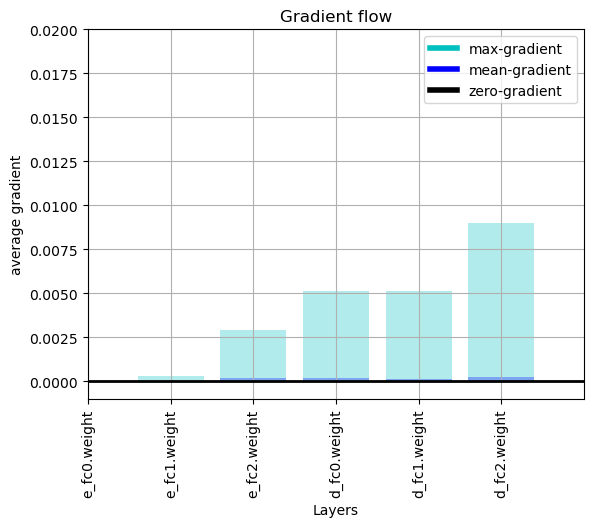

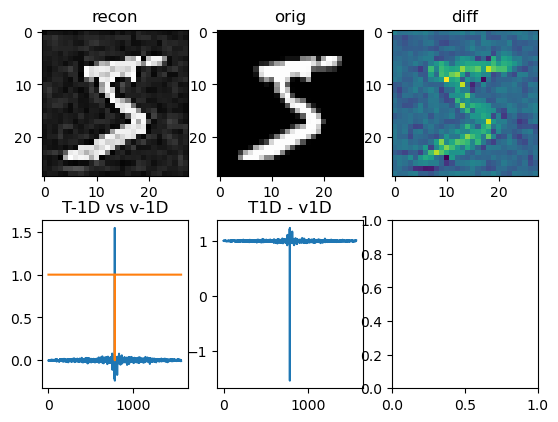

 80% (40 of 50) |###################     | Elapsed Time: 0:00:19 ETA:   0:00:03
 {'epoch': 40, 'train_mse': 0.005878582131117582, 'train_awi1d_loss': 0.1349235475063324}
 argidx T, v:  0 783


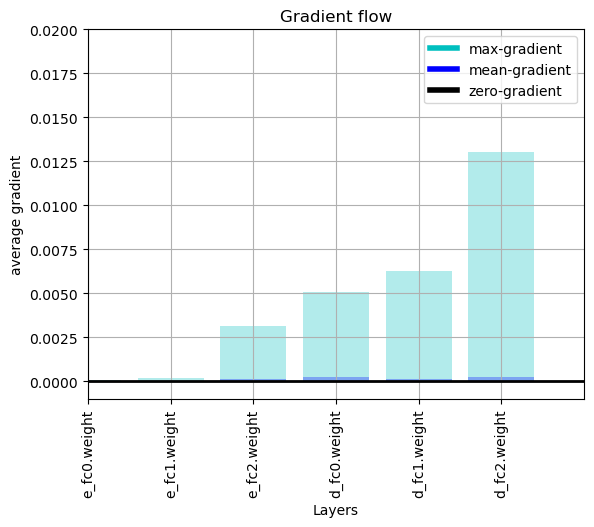

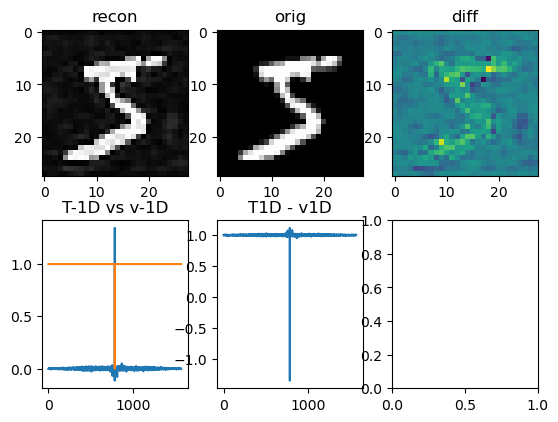

 98% (49 of 50) |####################### | Elapsed Time: 0:00:24 ETA:   0:00:00
 {'epoch': 49, 'train_mse': 0.002278258092701435, 'train_awi1d_loss': 0.10662173479795456}
 argidx T, v:  0 783


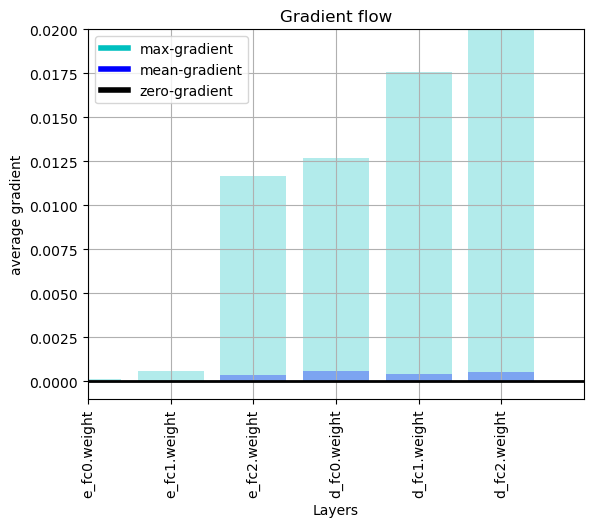

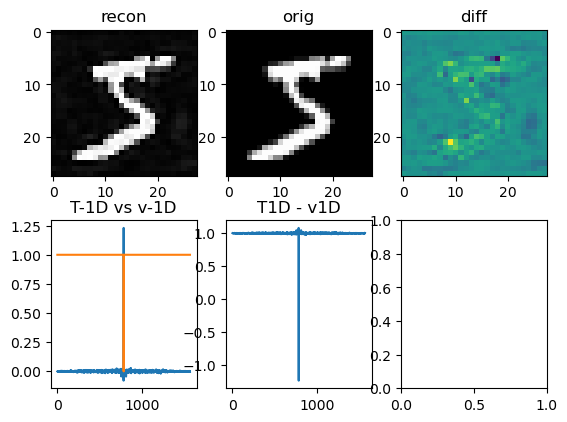

100% (50 of 50) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


In [40]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D(reduction="sum", std=1e-4, store_filters=True)
switch_at_epoch = 2 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss = train_ae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss = train_ae(model, train_loader, optimizer, awi1D, device=device)
            
        epoch_mse = validate_ae(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            f = awi1D(recon, X)
            v, T = awi1D.v_all[0], awi1D.T_arr

            print("\n", log)
            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())

            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].plot(v.detach().cpu().numpy())
            axs[1, 0].plot(T.flatten().detach().cpu().numpy())
            axs[1, 0].set_title("T-1D vs v-1D")

            axs[1, 1].plot((T.flatten() - v).detach().cpu().numpy())
            axs[1, 1].set_title("T1D - v1D")

            plt.show()


Angle between x_dir and y_dir: 89.98 °
100% (625 of 625) |######################| Elapsed Time: 0:02:07 Time:  0:02:07
Traceback (most recent call last):
  File "/home/dekape/miniconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/dekape/miniconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dekape/miniconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


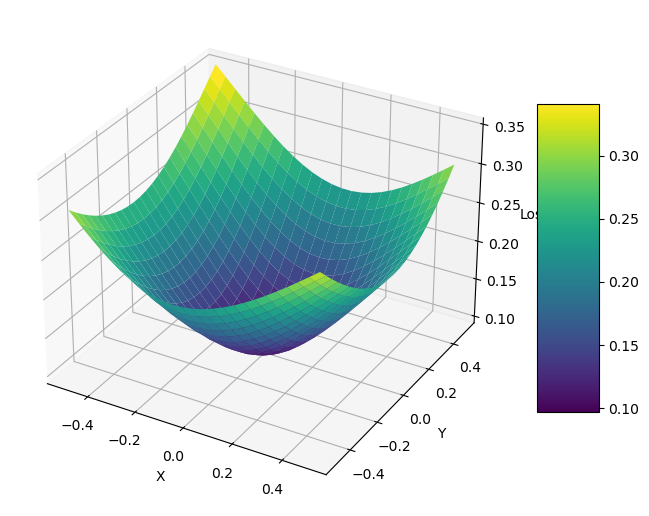

In [56]:
xx, yy, loss_landscape = visualise_landscape(model, train_loader, awi1D, device=device)

## Variational Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.2348046600818634, 'train_loss': 4.997922420501709, 'train_kl_loss': 50.60936737060547}
 argidx T, v:  783 595


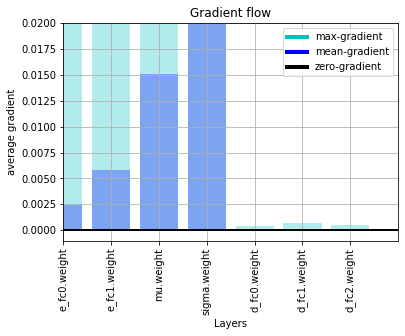

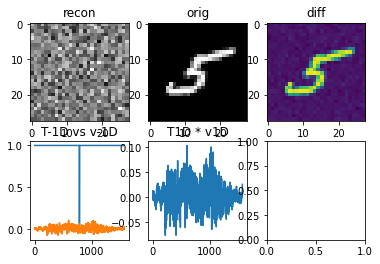

 14% (7 of 50) |###                      | Elapsed Time: 0:00:32 ETA:   0:02:55


KeyboardInterrupt: 

In [6]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D_extended(reduction="sum", std=1e-4, return_filters=False)
awi1D_val = AWLoss1D_extended(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 0 # swtich from mse + kl to awi+kl loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, awi1D, device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon, _, _ = model(X)
            _, v, T = awi1D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())


            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].plot(T.flatten().detach().cpu().numpy())
            axs[1, 0].plot(v.detach().cpu().numpy())
            axs[1, 0].set_title("T-1D vs v-1D")

            axs[1, 1].plot((T.flatten()*v).detach().cpu().numpy())
            axs[1, 1].set_title("T1D * v1D")

            plt.show()


# CIFAR10 Example

In [ ]:
# Train Transforms
train_transform = Compose([
    Resize(28),
    Grayscale(),
    ToTensor(),
])

# Datasets and dataloaders
ds = CIFAR10("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
# trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

trainds = Subset(ds, [0])

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 1:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

## Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse_loss': 0.07033240050077438, 'train_awi1d_loss': 0.49628475308418274}
 argidx T, v:  783 783


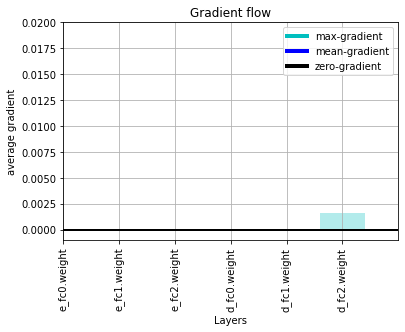

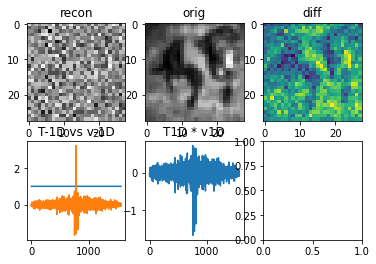

 20% (10 of 50) |####                    | Elapsed Time: 0:01:26 ETA:   0:06:47


 {'epoch': 10, 'train_mse_loss': 0.09172333031892776, 'train_awi1d_loss': 0.3069608211517334}
 argidx T, v:  783 783


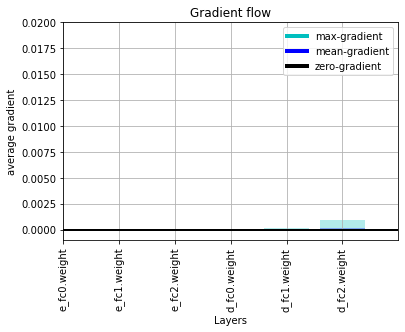

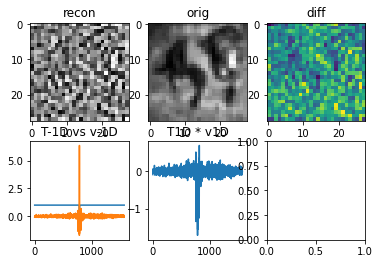

 40% (20 of 50) |#########               | Elapsed Time: 0:03:14 ETA:   0:08:41


 {'epoch': 20, 'train_mse_loss': 0.09602660685777664, 'train_awi1d_loss': 0.2424156367778778}
 argidx T, v:  783 783


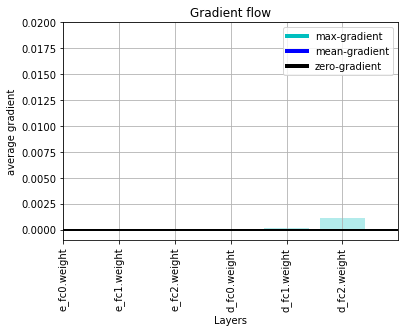

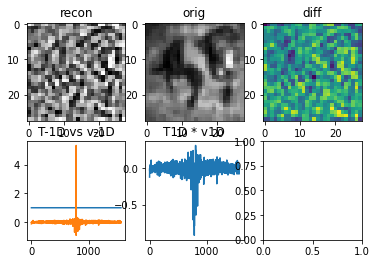

 60% (30 of 50) |##############          | Elapsed Time: 0:05:17 ETA:   0:03:51


 {'epoch': 30, 'train_mse_loss': 0.0887899175286293, 'train_awi1d_loss': 0.2065049707889557}
 argidx T, v:  783 783


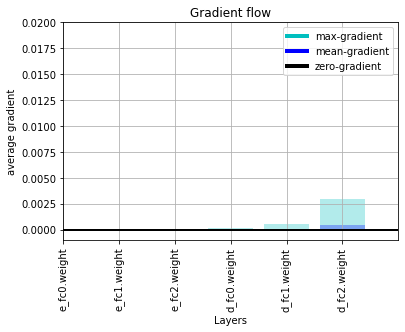

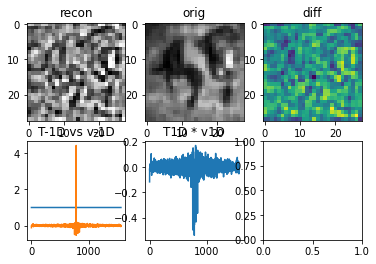

 80% (40 of 50) |###################     | Elapsed Time: 0:07:09 ETA:   0:01:45


 {'epoch': 40, 'train_mse_loss': 0.08050300180912018, 'train_awi1d_loss': 0.1778767704963684}
 argidx T, v:  783 783


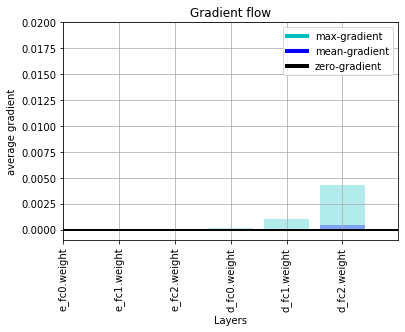

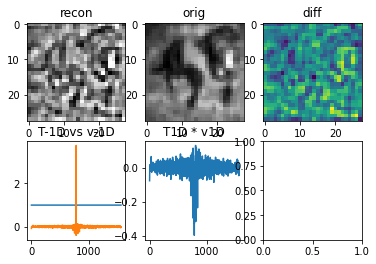

 98% (49 of 50) |####################### | Elapsed Time: 0:08:52 ETA:   0:00:13


 {'epoch': 49, 'train_mse_loss': 0.07553311437368393, 'train_awi1d_loss': 0.16072788834571838}
 argidx T, v:  783 783


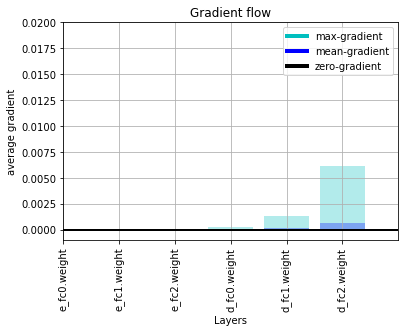

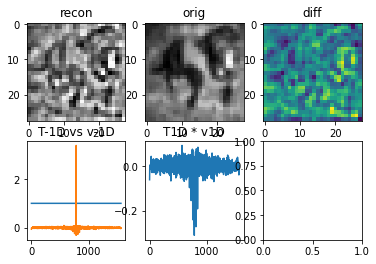

100% (50 of 50) |########################| Elapsed Time: 0:08:54 Time:  0:08:54


In [37]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D_extended(reduction="sum", std=1e-4, return_filters=False)
awi1D_val = AWLoss1D_extended(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss, epoch_mse = train_ae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss, epoch_mse = train_ae(model, train_loader, optimizer, awi1D, device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse_loss":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            _, v, T = awi1D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())

            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].plot(T.flatten().detach().cpu().numpy())
            axs[1, 0].plot(v.detach().cpu().numpy())
            axs[1, 0].set_title("T-1D vs v-1D")

            axs[1, 1].plot((T.flatten()*v).detach().cpu().numpy())
            axs[1, 1].set_title("T1D * v1D")

            plt.show()
